# SIRD Transport

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import deepxde as dde

from deepxde.backend import tf
from scipy.integrate import solve_ivp

sns.set_theme(style="darkgrid")

# dde.config.set_default_float("float64")
%matplotlib inline

Using backend: tensorflow.compat.v1

2023-03-06 01:11:26.452304: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 01:11:26.520788: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-06 01:11:26.833945: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/alonsolml/mambaforge/envs/pinn/

Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



2023-03-06 01:11:27.135474: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-06 01:11:27.147956: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-06 01:11:27.148003: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Model

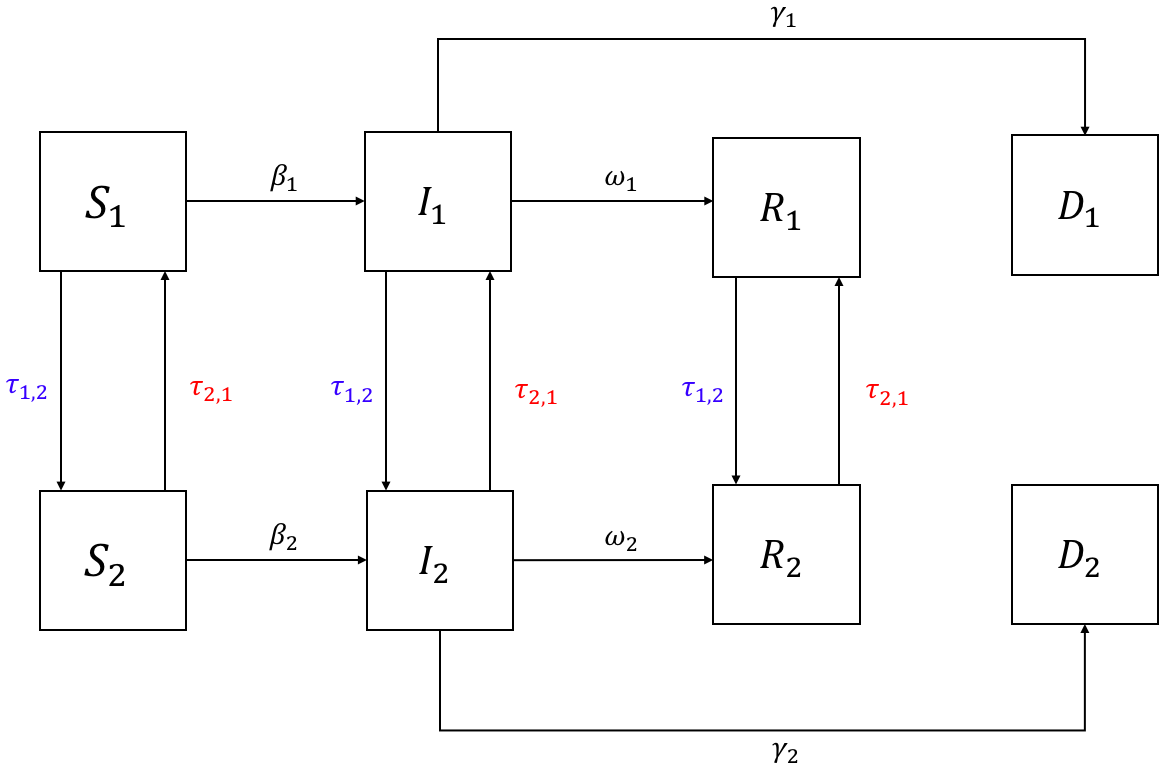

$$
\begin{aligned}
\frac{dS_1}{dt} &= - \frac{\beta_1}{N_1}  S_1 I_1  - \tau_{1,2} S_1 + \tau_{2,1} S_2 \\
\frac{dI_1}{dt} &= \frac{\beta_1}{N_1} S_1 I_1 - \omega_1 I_1 - \gamma_1  I_1 - \tau_{1,2} I_1 + \tau_{2,1} I_2\\
\frac{dR_1}{dt} &= \omega_1 I_1 - \tau_{1,2} R_1 + \tau_{2,1} R_2\\
\frac{dD_1}{dt} &= \gamma_1 I_1 \\
\\
\frac{dS_2}{dt} &= - \frac{\beta_2}{N_2}  S_2 I_2 - \tau_{2,1} S_2 + \tau_{1,2} S_1 \\
\frac{dI_2}{dt} &= \frac{\beta_2}{N_2} S_2 I_2 - \omega_2  I_2 - \gamma_2 I_2  - \tau_{2,1} I_2 + \tau_{1,2} I_1\\
\frac{dR_2}{dt} &= \omega_2 I_2 - \tau_{2,1} R_2 + \tau_{1,2} R_1\\
\frac{dD_2}{dt} &= \gamma_2 I_2
\end{aligned}
$$

| Variable   | Description |
| ----------- | ----------- |
| $S_i(t)$ | Number of __susceptible__ individuals in region $i$|
| $I_i(t)$ | Number of __symptomatically infected__ individuals in region $i$|
| $R_i(t)$ | Number of __removed__ individuals in region $i$|
| $D_i(t)$ | Number of __deceased__ individuals in region $i$|

| Parameter   | Description |
| ----------- | ----------- |
| $\beta_i$ | Transmission rate in region $i$ |
| $\omega_i$ | Recovery rate in region $i$ |
| $\gamma_i$ | Mortality rate in region $i$ |
| $\tau_{i,j}$ | Transportation rate from region $i$ to region $j$ |


## Synthetic data

In [2]:
N1 = 1e7
S1_0 = N1 - 1
I1_0 = 1
R1_0 = 0
D1_0 = 0

N2 = 9e6
S2_0 = N2 - 1
I2_0 = 1
R2_0 = 0
D2_0 = 0

y0 = [S1_0, I1_0, R1_0, D1_0, S2_0, I2_0, R2_0, D2_0]

beta1 = 0.5
omega1 = 1 / 14
gamma1 = 0.04 / 14
beta2 = 0.45
omega2 = 1 / 12
gamma2 = 0.045 / 14
tau12 = 0.01
tau21 = 0.02

parameters_real = {
    "beta1": beta1,
    "omega1": omega1,
    "gamma1": gamma1,
    "beta2": beta2,
    "omega2": omega2,
    "gamma2": gamma2,
    "tau12": tau12,
    "tau21": tau21
}

In [3]:
def generate_data(
    t_array,
    y0,
):

    def func(t, y):
        S1, I1, R1, D1, S2, I2, R2, D2 = y
        dS1_dt = - beta1 * S1 / N1 * I1 - tau12 * S1 + tau21 * S2
        dI1_dt = beta1 * S1 / N1 * I1 - omega1 * I1 - gamma1 * I1 - tau12 * I1 + tau21 * I2 
        dR1_dt = omega1 * I1 - tau12 * R1 + tau21 * R2
        dD1_dt = gamma1 * I1
        dS2_dt = - beta2 * S2 / N2 * I2 - tau21 * S2 + tau12 * S1
        dI2_dt = beta2 * S2 / N2 * I2 - omega2 * I2 - gamma2 * I2 - tau21 * I2 + tau12 * I1
        dR2_dt = omega2 * I2 - tau21 * R2 + tau12 * R1
        dD2_dt = gamma2 * I2
        return np.array([dS1_dt, dI1_dt, dR1_dt, dD1_dt, dS2_dt, dI2_dt, dR2_dt, dD2_dt])

    t_span = (t_array[0], t_array[-1])
    sol = solve_ivp(func, t_span, y0, t_eval=t_array)
    return sol.y.T

In [4]:
n_days = 120
t_train = np.arange(0, n_days, 1)[:, np.newaxis]
y_train = generate_data(np.ravel(t_train), y0)

In [5]:
model_name = "SIRD Transport"
populations_names = ["S1", "I1", "R1", "D1", "S2", "I2", "R2", "D2"]
data_real = (
    pd.DataFrame(y_train, columns=populations_names, index=t_train.ravel())
    .rename_axis("time")
    .reset_index()
    .melt(id_vars="time", var_name="status_region", value_name="population")
    .assign(
        status=lambda x: x["status_region"].str[0],
        region=lambda x: x["status_region"].str[1],
    )
)

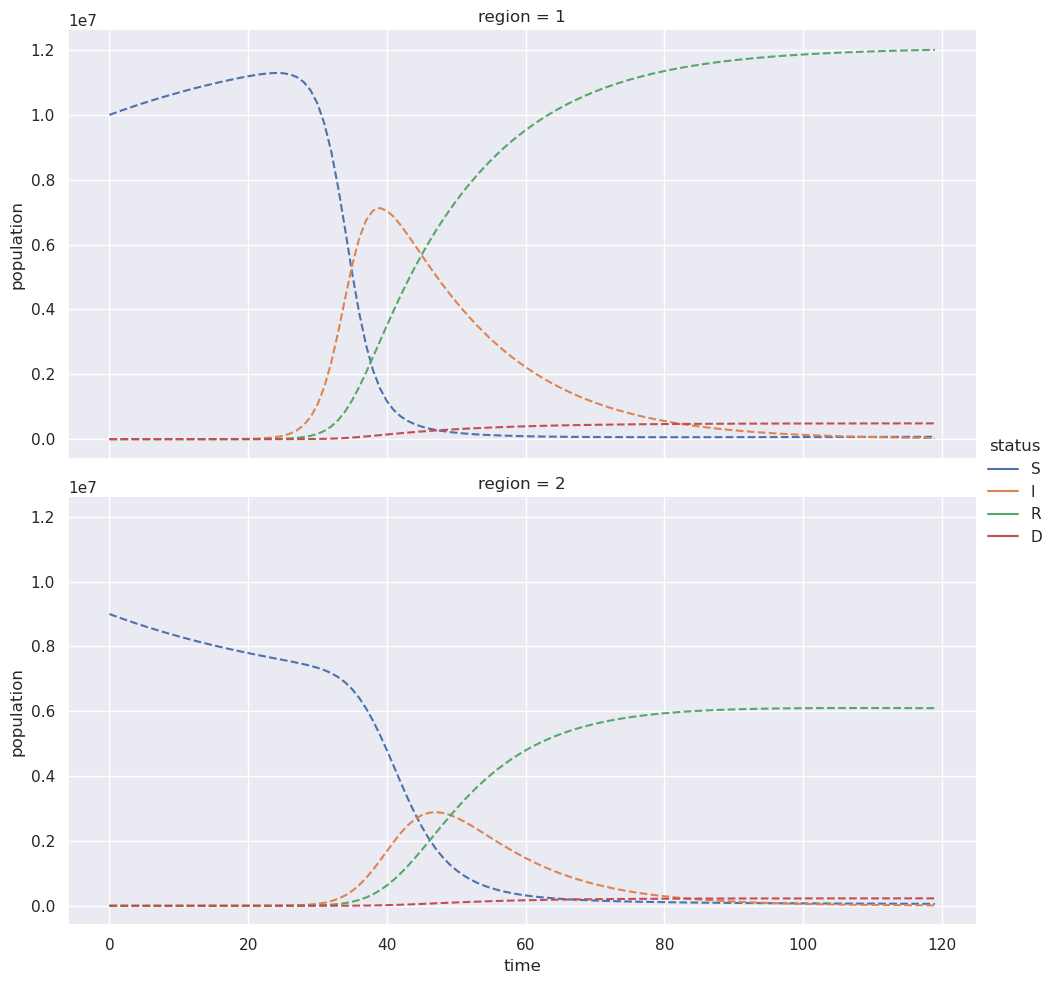

In [6]:
g = sns.relplot(
    data=data_real,
    x="time",
    y="population",
    row="region",
    hue="status",
    kind="line",
    linestyle="dashed",
    aspect=2,
)

## DINN

In [7]:
def dinn(
    data_t,
    data_y,
    parameters,
    hyperparameters
):    
        
    # Variables
    _beta1 = dde.Variable(0.0)
    _omega1 = dde.Variable(0.0)
    _gamma1 = dde.Variable(0.0)
    _beta2 = dde.Variable(0.0)
    _omega2 = dde.Variable(0.0)
    _gamma2 = dde.Variable(0.0)
    _tau12 = dde.Variable(0.0)
    _tau21 = dde.Variable(0.0)

    variables_list = [
        _beta1,
        _omega1,
        _gamma1,
        _beta2,
        _omega2,
        _gamma2,
        _tau12,
        _tau21
    ]
    
    # ODE model
    def ode(t, y):

        S1 = y[:, 0:1]
        I1 = y[:, 1:2]
        R1 = y[:, 2:3]
        D1 = y[:, 3:4]
        S2 = y[:, 4:5]
        I2 = y[:, 5:6]
        R2 = y[:, 6:7]
        D2 = y[:, 7:8]

        dS1_dt = dde.grad.jacobian(y, t, i=0)
        dI1_dt = dde.grad.jacobian(y, t, i=1)
        dR1_dt = dde.grad.jacobian(y, t, i=2)
        dD1_dt = dde.grad.jacobian(y, t, i=3)
        dS2_dt = dde.grad.jacobian(y, t, i=4)
        dI2_dt = dde.grad.jacobian(y, t, i=5)
        dR2_dt = dde.grad.jacobian(y, t, i=6)
        dD2_dt = dde.grad.jacobian(y, t, i=7)


        return [
            dS1_dt - (- _beta1 * S1 / N1 * I1 - _tau12 * S1 + _tau21 * S2),
            dI1_dt - (_beta1 * S1 / N1 * I1 - _omega1 * I1 - _gamma1 * I1 - _tau12 * I1 + _tau21 * I2 ),
            dR1_dt - (_omega1 * I1 - _tau12 * R1 + _tau21 * R2),
            dD1_dt - (_gamma1 * I1),
            dS2_dt - (- _beta2 * S2 / N2 * I2 - _tau21 * S2 + _tau12 * S1),
            dI2_dt - (_beta2 * S2 / N2 * I2 - _omega2 * I2 - _gamma2 * I2 - _tau21 * I2 + _tau12 * I1),
            dR2_dt - (_omega2 * I2 - _tau21 * R2 + _tau12 * R1),
            dD2_dt - (_gamma2 * I2)
        ]

    # Geometry
    geom = dde.geometry.TimeDomain(data_t[0, 0], data_t[-1, 0])
    
    # Boundaries
    def boundary(_, on_initial):
        return on_initial
    
    # Initial conditions
    S1_0, I1_0, R1_0, D1_0, S2_0, I2_0, R2_0, D2_0 = data_y[0, :]
    ic_S1 = dde.icbc.IC(geom, lambda x: S1_0, boundary, component=0)
    ic_I1 = dde.icbc.IC(geom, lambda x: I1_0, boundary, component=1)
    ic_R1 = dde.icbc.IC(geom, lambda x: R1_0, boundary, component=2)
    ic_D1 = dde.icbc.IC(geom, lambda x: D1_0, boundary, component=3)
    ic_S2 = dde.icbc.IC(geom, lambda x: S2_0, boundary, component=4)
    ic_I2 = dde.icbc.IC(geom, lambda x: I2_0, boundary, component=5)
    ic_R2 = dde.icbc.IC(geom, lambda x: R2_0, boundary, component=6)
    ic_D2 = dde.icbc.IC(geom, lambda x: D2_0, boundary, component=7)

    # Train data
    observe_S1 = dde.icbc.PointSetBC(data_t, data_y[:, 0:1], component=0)
    observe_I1 = dde.icbc.PointSetBC(data_t, data_y[:, 1:2], component=1)
    observe_R1 = dde.icbc.PointSetBC(data_t, data_y[:, 2:3], component=2)
    observe_D1 = dde.icbc.PointSetBC(data_t, data_y[:, 3:4], component=3)
    observe_S2 = dde.icbc.PointSetBC(data_t, data_y[:, 4:5], component=4)
    observe_I2 = dde.icbc.PointSetBC(data_t, data_y[:, 5:6], component=5)
    observe_R2 = dde.icbc.PointSetBC(data_t, data_y[:, 6:7], component=6)
    observe_D2 = dde.icbc.PointSetBC(data_t, data_y[:, 7:8], component=7)
    
    # Model
    data = dde.data.PDE(
        geom,
        ode,
        [
            # ic_S1,
            # ic_I1,
            # ic_R1,
            # ic_D1,
            # ic_S2,
            # ic_I2,
            # ic_R2,
            # ic_D2,
            observe_S1,
            observe_I1,
            observe_R1,
            observe_D1,
            observe_S2,
            observe_I2,
            observe_R2,
            observe_D2

        ],
        num_domain=512,
        num_boundary=2,
        # train_distribution="uniform",
        anchors=data_t,
    )
    
    neurons = hyperparameters["neurons"]
    layers = hyperparameters["layers"]
    activation = hyperparameters["activation"]
    net = dde.nn.FNN([1] + [neurons] * layers + [8], activation, "Glorot uniform")
    
    def feature_transform(t):
        t = t / data_t[-1, 0]
        return t

    net.apply_feature_transform(feature_transform)

    variable = dde.callbacks.VariableValue(
        variables_list,
        period=100,
        filename="sird_transport_variables_no_prior_knowledge.dat"
    )

    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        loss_weights=hyperparameters["loss_weights"],
        external_trainable_variables=variables_list
    )
    losshistory, train_state = model.train(
        iterations=hyperparameters["iterations"],
        display_every=10000,
        callbacks=[variable]
    )

    model.compile("L-BFGS", external_trainable_variables=variables_list)
    losshistory, train_state = model.train(callbacks=[variable])

    dde.saveplot(losshistory, train_state, issave=False, isplot=True)

    parameters_pred = {
        name: var for name, var in zip(parameters_real.keys(), variable.value)
    }

    return model, losshistory, train_state, parameters_pred, variable

Compiling model...
Building feed-forward neural network...
'build' took 0.027729 s



/home/alonsolml/mambaforge/envs/pinn/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2023-03-06 01:11:28.082715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 01:11:28.083500: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-06 01:11:28.083555: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file t

'compile' took 0.954313 s

Initializing variables...
Training model...



2023-03-06 01:11:29.020888: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-03-06 01:11:29.069329: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fbda4011e30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-06 01:11:29.069351: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-03-06 01:11:29.096120: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-06 01:11:29.124074: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-03-06 01:11:29.185202: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-06 01:

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
0         [1.26e-07, 3.54e-08, 1.93e-07, 1.33e-08, 2.32e-09, 5.41e-07, 7.03e-10, 3.42e-07, 3.29e+13, 6.21e+12, 7.39e+13, 1.24e+11, 2.10e+13, 1.11e+12, 1.89e+13, 2.56e+10]    [1.26e-07, 3.54e-08, 1.93e-07, 1.33e-08, 2.32e-09, 5.41e-07, 7.03e-10, 3.42e-07, 3.29e+13, 6.21e+12, 7.39e+13, 1.24e+11, 2.10e+13, 1.11e+12, 1.89e+13, 2.56e+10]    []  
10000     [6.05e+08, 6.77e+08, 2.97e+09, 6.21e+08, 5.96e+08, 6.52e+08, 1.21e+09, 6.16e+08, 3.15e+13, 5.06e+12, 4.27e+12, 7.38e+09, 1.96e+13, 8.70e+11, 1.45e+12, 1.95e+09]    [6.05e+08, 6.77e+08, 2.97e+09, 6.21e+08, 5.96e+08, 6.52e+08, 1.21e+09, 6.16e+08, 3.15e+13, 5.06e+12, 4.27e+12, 7.38e+09, 1.96e+13, 8.

2023-03-06 01:12:31.028833: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1780] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).


Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
30000     [3.97e+09, 1.68e+09, 2.72e+08, 1.83e+06, 4.58e+09, 2.77e+08, 2.01e+08, 1.38e+06, 1.57e+10, 2.05e+09, 1.34e+08, 9.44e+05, 2.51e+10, 2.18e+08, 1.27e+08, 5.25e+05]    [3.97e+09, 1.68e+09, 2.72e+08, 1.83e+06, 4.58e+09, 2.77e+08, 2.01e+08, 1.38e+06, 1.57e+10, 2.05e+09, 1.34e+08, 9.44e+05, 2.51e+10, 2.18e+08, 1.27e+08, 5.25e+05]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 54104989696.000000
  Number of iterations: 3
  Number of functions evaluations: 23
30023     [3.91e+09, 1.69e+09, 2.66e+08, 1.96e+06, 4.56e+09, 2.80e+08, 1.91e+08, 1.42e+06, 

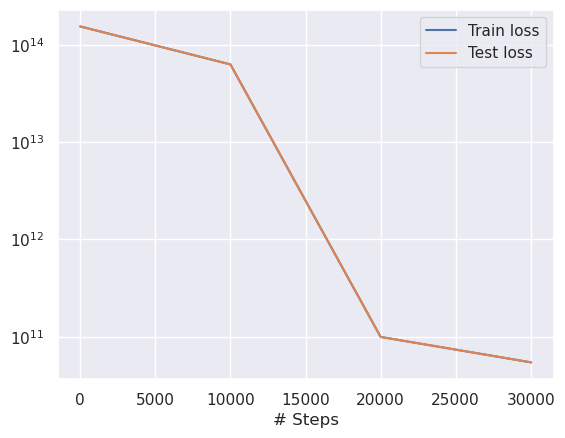

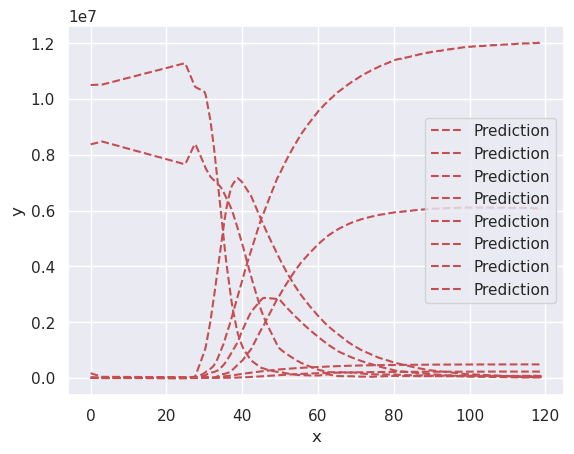

In [8]:
hyperparameters = {
    "search_range": (0.2, 1.8),
    "iterations": 30000,
    "layers": 5,
    "neurons": 64,
    "activation": "relu",
    "loss_weights": [
        1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1
    ]
}
model, losshistory, train_state, parameters_pred, variable = dinn(
    data_t=t_train,
    data_y=y_train,
    parameters=parameters_real,
    hyperparameters=hyperparameters
)

In [9]:
t_pred =  np.arange(0, n_days, 1)[:, np.newaxis]
y_pred = model.predict(t_pred)
data_pred = (
    pd.DataFrame(y_pred, columns=populations_names, index=t_pred.ravel())
    .rename_axis("time")
    .reset_index()
    .melt(id_vars="time", var_name="status_region", value_name="population")
    .assign(
        status=lambda x: x["status_region"].str[0],
        region=lambda x: x["status_region"].str[1],
    )
)

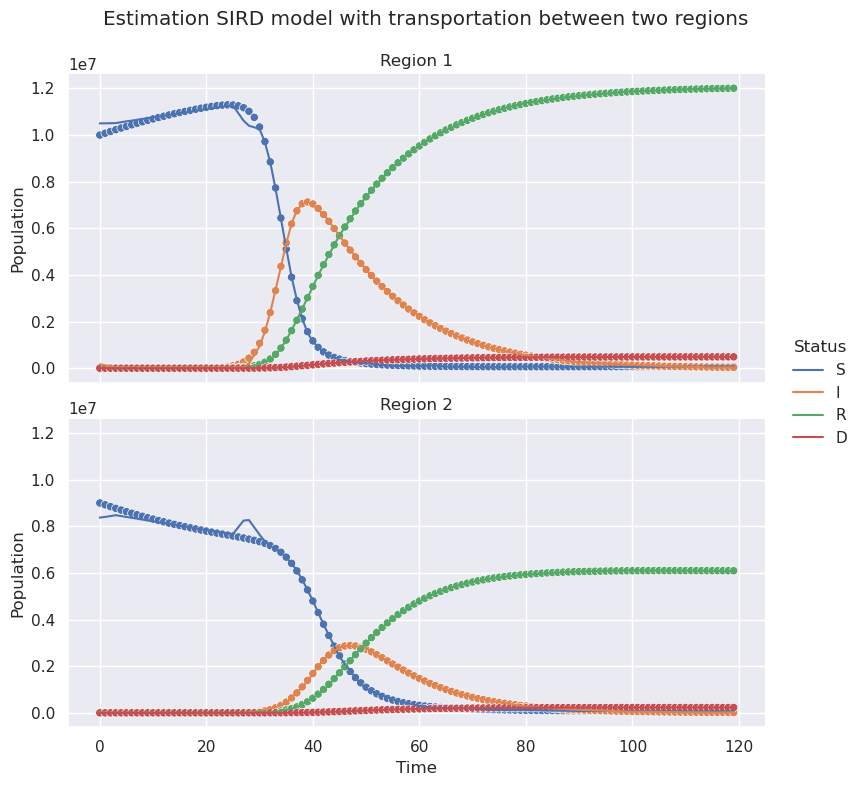

In [16]:
g = sns.relplot(
    data=data_pred,
    x="time",
    y="population",
    row="region",
    hue="status",
    kind="line",
    aspect=2,
    height=4
)

for region, ax in g.axes_dict.items():
    sns.scatterplot(
        data=data_real.query("region == @region"),
        x="time",
        y="population",
        hue="status",
        ax=ax,
        legend=False
    )

(
    g.set_axis_labels("Time", "Population")
    .set_titles("Region {row_name}")
    .tight_layout(w_pad=1)
)

g._legend.set_title("Status")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle(f"Estimation SIRD model with transportation between two regions")
plt.savefig("sird_transport_parameter_estimation_no_prior_knowledge.png", dpi=300)
plt.show()

In [11]:
lines = open("sird_transport_variables_no_prior_knowledge.dat", "r").readlines()
raw_parameters_pred_history = np.array(
    [
         np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)
iterations = [int(re.findall("^[0-9]+", line)[0]) for line in lines]
parameters_pred_history = {   
    name: raw_parameters_pred_history[:, i]
    for i, (name, nominal) in enumerate(parameters_real.items())
}

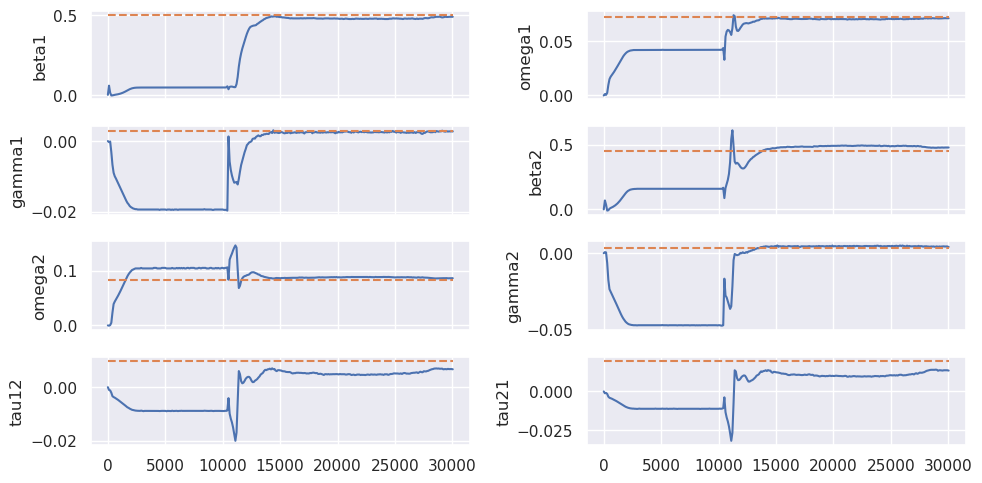

In [12]:
n_callbacis, n_variables = raw_parameters_pred_history.shape
fig, axes = plt.subplots(nrows=n_variables // 2, ncols=2, sharex=True, figsize=(10, 5))
for ax, (parameter, parameter_value) in zip(axes.flatten(), parameters_real.items()):
    ax.plot(iterations, parameters_pred_history[parameter] , "-")
    ax.plot(iterations, np.ones_like(iterations) * parameter_value, "--")
    ax.set_ylabel(parameter)
# ax.set_xlabel("Iterations")
fig.tight_layout()
fig.savefig("sird_transport_variables_no_prior_knowledge.png", dpi=300)

In [13]:
error_df = (
    pd.DataFrame(
        {
            "Real": parameters_real,
            "Predicted": parameters_pred
        }
    )
    .assign(
        **{"Relative Error": lambda x: (x["Real"] - x["Predicted"]).abs() / x["Real"]}
    )
)
error_df

,Real,Predicted,Relative Error
beta1,0.500000,0.489755,0.020489
omega1,0.071429,0.070538,0.012464
gamma1,0.002857,0.002732,0.043673
beta2,0.450000,0.478346,0.062991
omega2,0.083333,0.086211,0.034535
gamma2,0.003214,0.004125,0.283196
tau12,0.010000,0.006717,0.328336
tau21,0.020000,0.013535,0.323251


In [14]:
print(
    error_df.style
    .format(
        {
            "Real": "{:.4f}",
            "Predicted": "{:.4f}",
            "Relative Error": "{:.4f}",
        }
    ).to_latex(
        label="tab:sird_transport_errors",
        caption="Parameter predictions and relative errors for SIRD model with transport.",   
    )
)

\begin{table}
\caption{Parameter predictions and relative errors for SIRD model with transport.}
\label{tab:sird_transport_errors}
\begin{tabular}{lrrr}
 & Real & Predicted & Relative Error \\
beta1 & 0.5000 & 0.4898 & 0.0205 \\
omega1 & 0.0714 & 0.0705 & 0.0125 \\
gamma1 & 0.0029 & 0.0027 & 0.0437 \\
beta2 & 0.4500 & 0.4783 & 0.0630 \\
omega2 & 0.0833 & 0.0862 & 0.0345 \\
gamma2 & 0.0032 & 0.0041 & 0.2832 \\
tau12 & 0.0100 & 0.0067 & 0.3283 \\
tau21 & 0.0200 & 0.0135 & 0.3233 \\
\end{tabular}
\end{table}

